<a href="https://colab.research.google.com/github/rachitch11/US-Houses-Price-Prediction-Model/blob/main/myassignment_Home_Price_Model_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 US Home Price Analysis (2005-2025)
This notebook models how key economic factors influenced the S&P Case-Shiller Home Price Index over the last 20 years.

In [78]:
pip install pandas matplotlib seaborn scikit-learn statsmodels fredapi

In [79]:
#  Step 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from fredapi import Fred
from sklearn.linear_model import LinearRegression

In [80]:
#  Step 3: Set FRED API Key (Replace with your key)
fred = Fred(api_key='bbee76c5ee8ac594dd4d91c993369086')

In [92]:
#  Step 4: Download Data from FRED (Expanded Set)
home_price = fred.get_series('CSUSHPISA').rename("HomePrice")
gdp_growth = fred.get_series('GDP').rename("GDPGrowth")
mortgage_rate = fred.get_series('MORTGAGE30US').rename("MortgageRate")
unemployment = fred.get_series('UNRATE').rename("Unemployment")
cpi = fred.get_series('CPIAUCSL').rename("CPI")
housing_starts = fred.get_series('HOUST').rename("HousingStarts")

# Additional Factors
income = fred.get_series('DSPIC96').rename("PersonalIncome")         # Real disposable personal income
population = fred.get_series('POP').rename("Population")             # U.S. population
construction_spending = fred.get_series('TLRESCONS').rename("ConstructionSpending")  # Residential construction spending
median_rent = fred.get_series('CUUR0000SEHA').rename("MedianRent")   # CPI for Rent
homeownership_rate = fred.get_series('RHORUSQ156N').rename("HomeownershipRate")  # % of households owning homes

In [93]:
#  Step 5: Resample to Monthly Frequency & Clean Data

# Resample all data to monthly frequency
home_price = home_price.resample('ME').mean()
gdp_growth = gdp_growth.resample('ME').ffill()
mortgage_rate = mortgage_rate.resample('ME').mean()
unemployment = unemployment.resample('ME').mean()
cpi = cpi.resample('ME').mean()
housing_starts = housing_starts.resample('ME').mean()

income = income.resample('ME').ffill()  # Personal income: forward fill
population = population.resample('ME').ffill()  # Population: forward fill
construction_spending = construction_spending.resample('ME').mean()
median_rent = median_rent.resample('ME').mean()
homeownership_rate = homeownership_rate.resample('ME').ffill()  # Homeownership rate: quarterly, so ffill

# Combine all data into a single DataFrame
data = pd.concat([
    home_price,
    gdp_growth,
    mortgage_rate,
    unemployment,
    cpi,
    housing_starts,
    income,
    population,
    construction_spending,
    median_rent,
    homeownership_rate
], axis=1)



# Drop missing values and filter for years 2005 onwards
data.dropna(inplace=True)
data = data.loc["2005-01-01":]



#converting float columns to int value
data['HousingStarts'] = pd.to_numeric(data['HousingStarts'], downcast='integer')
data['ConstructionSpending'] = pd.to_numeric(data['ConstructionSpending'], downcast='integer')

#rounding off data
cols_to_round = ["HomePrice", "GDPGrowth", "MortgageRate", "Unemployment", "CPI", "MedianRent", "PersonalIncome", "Population"]
data[cols_to_round] = data[cols_to_round].round(2)

# Preview the dataset
print("Final dataset shape:", data.shape)
data



Final dataset shape: (241, 11)


,HomePrice,GDPGrowth,MortgageRate,Unemployment,CPI,HousingStarts,PersonalIncome,Population,ConstructionSpending,MedianRent,HomeownershipRate
2005-01-31,161.29,12767.29,5.71,5.3,191.60,2144,11226.5,294914.00,581168,214.50,69.1
2005-02-28,163.35,12767.29,5.63,5.4,192.40,2207,11229.0,295105.00,594003,215.00,69.1
2005-03-31,165.81,12767.29,5.93,5.2,193.10,1864,11268.8,295287.00,597200,215.50,69.1
2005-04-30,167.50,12922.66,5.86,5.2,193.70,2061,11304.2,295490.00,603975,216.00,68.6
2005-05-31,169.35,12922.66,5.72,5.1,193.60,2025,11352.7,295704.00,609170,216.40,68.6
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,323.28,29374.91,6.18,4.1,314.85,1357,17519.6,340734.17,903941,423.82,65.6
2024-10-31,324.47,29723.86,6.43,4.1,315.56,1352,17586.3,340916.48,934237,425.38,65.7
2024-11-30,326.01,29723.86,6.80,4.2,316.45,1295,17618.0,341088.46,936848,426.65,65.7
2024-12-31,327.68,29723.86,6.72,4.1,317.60,1514,17638.6,341249.83,939666,428.15,65.7


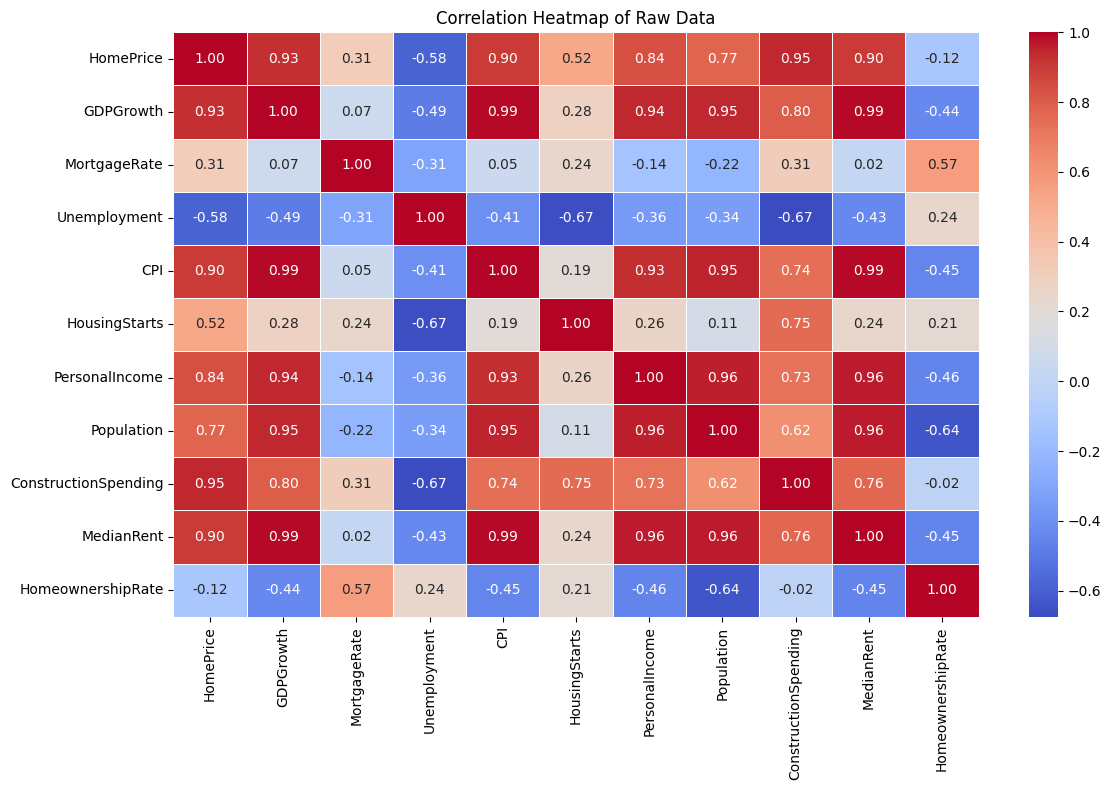

In [83]:
#  Step 6: Exploratory Data Analysis
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Raw Data")
plt.tight_layout()
plt.show()

In [84]:
#  Step 7: Feature Engineering - Percent Change
data_pct = data.pct_change().dropna()
data_pct.head()

,HomePrice,GDPGrowth,MortgageRate,Unemployment,CPI,HousingStarts,PersonalIncome,Population,ConstructionSpending,MedianRent,HomeownershipRate
2005-02-28,0.012772,0.000000,-0.014011,0.018868,0.004175,0.029384,0.000223,0.000648,0.022085,0.002331,0.000000
2005-03-31,0.015060,0.000000,0.053286,-0.037037,0.003638,-0.155415,0.003544,0.000617,0.005382,0.002326,0.000000
2005-04-30,0.010192,0.012169,-0.011804,0.000000,0.003107,0.105687,0.003141,0.000687,0.011345,0.002320,-0.007236
2005-05-31,0.011045,0.000000,-0.023891,-0.019231,-0.000516,-0.017467,0.004290,0.000724,0.008601,0.001852,0.000000
2005-06-30,0.010865,0.000000,-0.024476,-0.019608,0.000517,0.021235,0.002008,0.000785,0.022253,0.001848,0.000000


In [85]:
#  Step 8: Prepare Data for Modeling
X = data_pct.drop('HomePrice', axis=1)
y = data_pct['HomePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [86]:
#  Step 9: Train Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [87]:
#  Step 10: Evaluate Model
print("R² Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R² Score: 0.13251674162907512
Mean Squared Error: 3.8220245688689164e-05


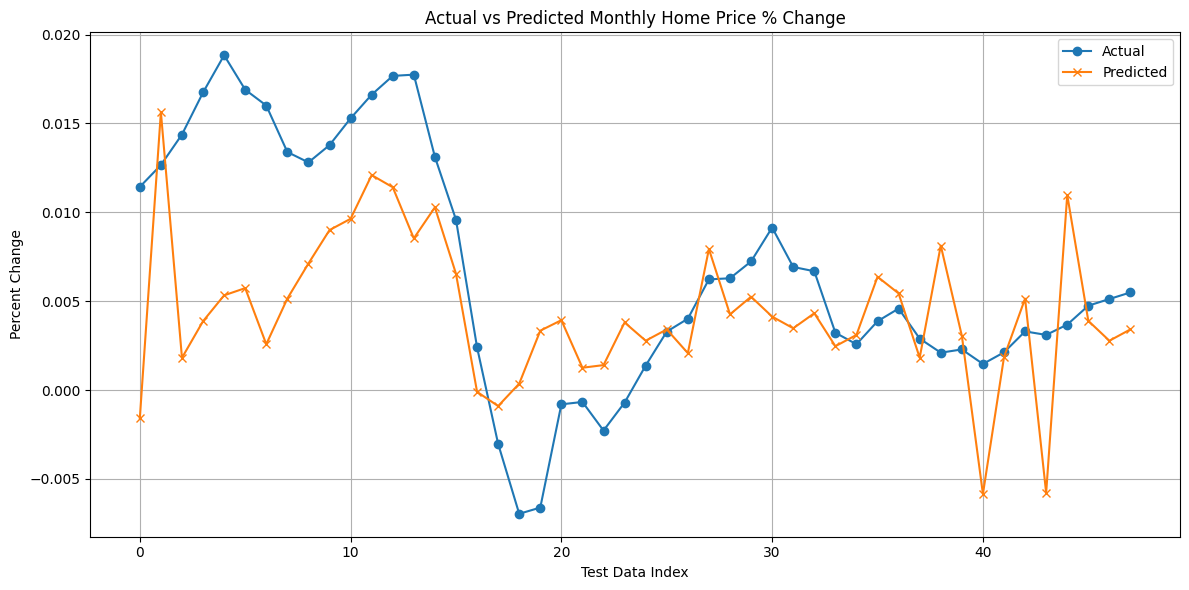

In [88]:
#  Step 11: Visualize Predictions vs Actual
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title("Actual vs Predicted Monthly Home Price % Change")
plt.xlabel("Test Data Index")
plt.ylabel("Percent Change")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

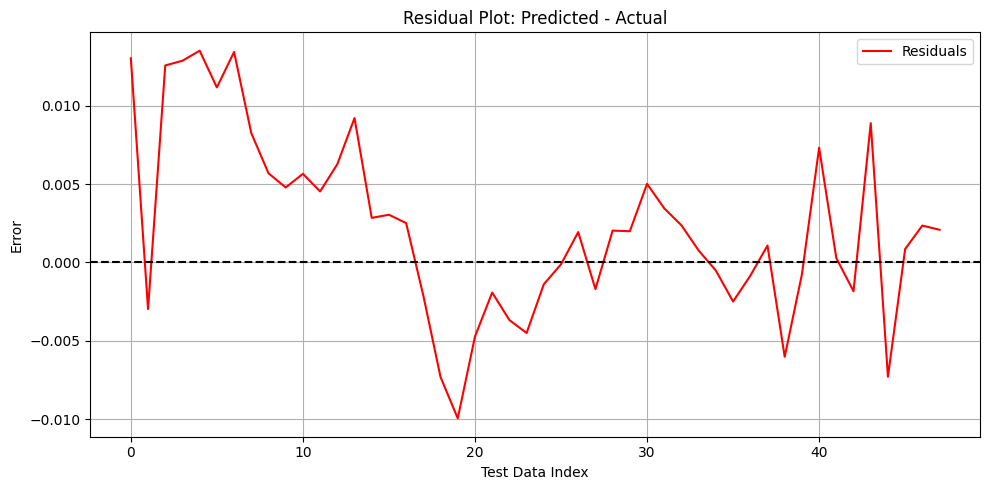

In [89]:
# Step 12: Residuals
residuals = y_test - y_pred

# Residual Plot
plt.figure(figsize=(10,5))
plt.plot(residuals.values, label='Residuals', color='red')
plt.axhline(0, linestyle='--', color='black')
plt.title("Residual Plot: Predicted - Actual")
plt.xlabel("Test Data Index")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [95]:
#Step 13: Evaluating the metrices
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(" Model Performance Summary:")
print("R² Score:", round(r2_score(y_test, y_pred), 4))
print("Mean Absolute Error (MAE):", round(mean_absolute_error(y_test, y_pred), 4))
print("Mean Squared Error (MSE):", round(mean_squared_error(y_test, y_pred), 4))

 Model Performance Summary:
R² Score: 0.1325
Mean Absolute Error (MAE): 0.0048
Mean Squared Error (MSE): 0.0


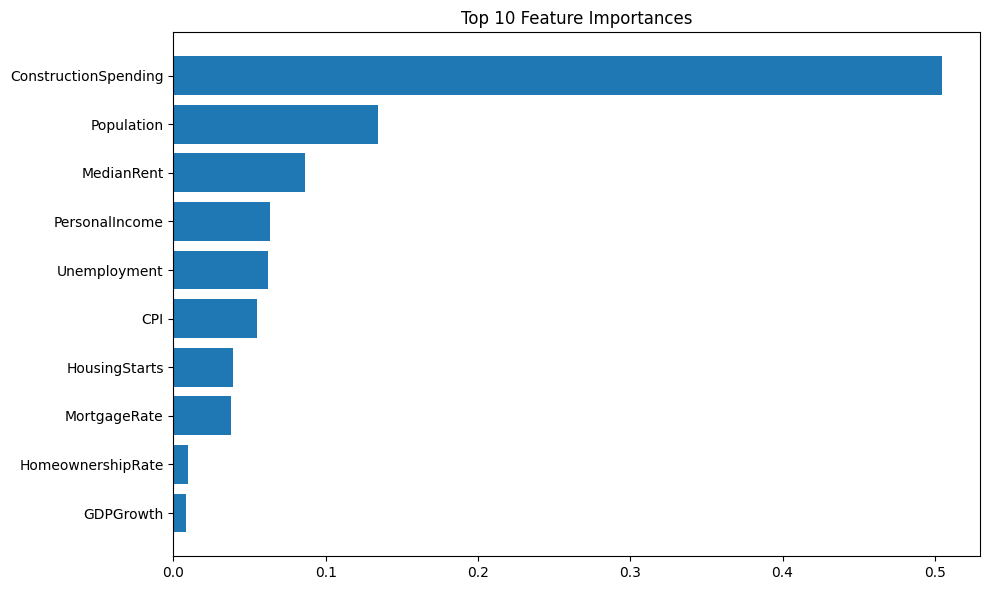

In [91]:
#Step 14: Feature Importance(Interpet Drivers)
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
features = X.columns
indices = importances.argsort()[::-1]

# Top 10 important features
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.barh(range(10), importances[indices][:10], align="center")
plt.yticks(range(10), [features[i] for i in indices[:10]])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()